In [1]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def tsplot(y, lags=15):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # layout
    fig = plt.figure(figsize=(14, 6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    # ts plot
    y.plot(ax=ts_ax)
    ts_ax.set_title('Time series');
    
    # acf, pacf
    plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

In [3]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print('H0: Unit root (nonstationarity) present')
    print('HA: No unit root')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    print('H0: Trend stationary')
    print('HA: Not trend stationary (has unit root)')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

První pohled na data

datum
2020-02-26    0
2020-02-27    0
2020-02-28    0
2020-02-29    0
2020-03-01    3
Name: prirustkovy_pocet_nakazenych, dtype: int64


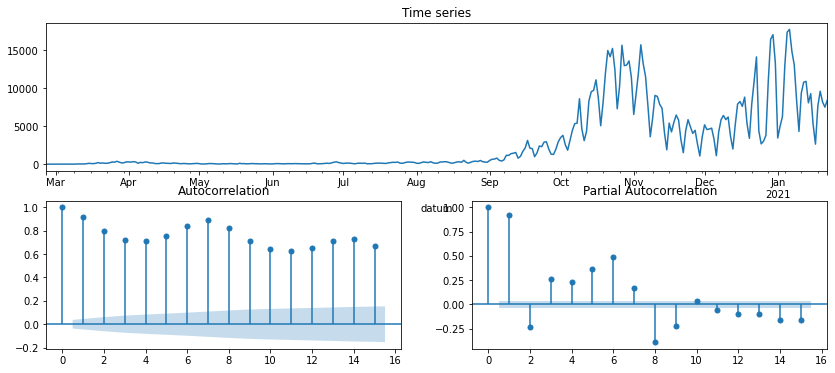

In [4]:
fileName = './nakaza.csv'
data = pd.read_csv(fileName, index_col=0, parse_dates=True).drop(columns=['kumulativni_pocet_nakazenych']).squeeze()
# data obsahuji nulove hodnoty od 27/1 do 29/2, rozhodl jsem se je oříznout
data = data[30:]
print(data[:5])
tsplot(data)

### Ověřím praveděpodobné vlastnosti řady pomocí ADF a KPSS testu

In [5]:
adf_test(data)
print('\n-------------------------------------------\n')
kpss_test(data)

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -1.840840
p-value                          0.360382
#Lags Used                      15.000000
Number of Observations Used    316.000000
Critical Value (1%)             -3.451215
Critical Value (5%)             -2.870730
Critical Value (10%)            -2.571666
dtype: float64

-------------------------------------------

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            2.048627
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


**adf**: p-value > 0.05 => Nezamítáme $H_0$

**kpss**: p-value < 0.05 => Zamítáme $H_0$

=> to nám říká, že řada je pravděpodobně nestacionarní a existuje jednotkový kořen

Je tedy potřeba diferencovat s cílem zbavení se trendu

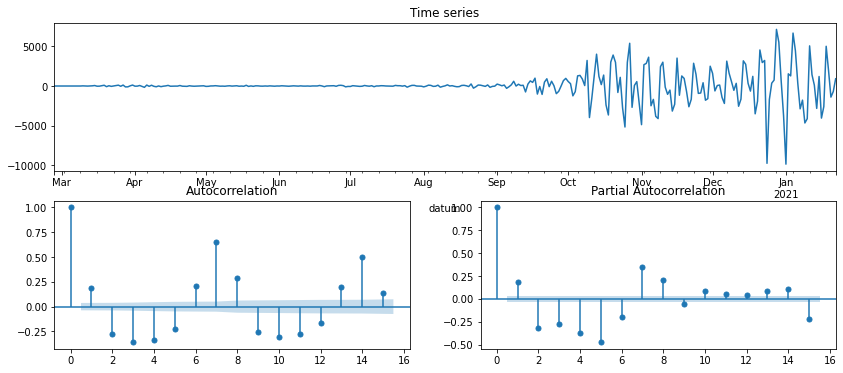

In [6]:
diff1 = data.diff().dropna()
tsplot(diff1)

In [7]:
adf_test(diff1)
print('\n-------------------------------------------\n')
kpss_test(diff1)

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -3.919186
p-value                          0.001898
#Lags Used                      14.000000
Number of Observations Used    316.000000
Critical Value (1%)             -3.451215
Critical Value (5%)             -2.870730
Critical Value (10%)            -2.571666
dtype: float64

-------------------------------------------

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            0.134889
p-value                   0.100000
Lags Used                71.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


**adf**: p-value < 0.05 => Zamítáme $H_0$

**kpss**: p-value > 0.05 => Nezamítáme $H_0$

-> Vypadá to, že jsme se globálního trendu nejspíše zbavili a data by již měla být stacionární (alespoň výsledky testů to indikují)

Dle grafů soudím (a hlavně i na základě informací o datech), že sezónnost je **s = 7**

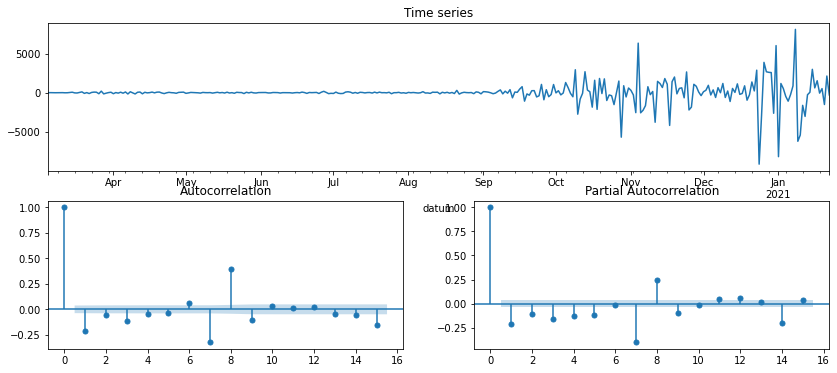

In [8]:
tsplot(diff1.diff(7).dropna())

In [9]:
# pro jistotu znovu i testy
adf_test(diff1.diff(7).dropna())
print('\n-------------------------------------------\n')
kpss_test(diff1.diff(7).dropna())

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                -6.670043e+00
p-value                        4.612430e-09
#Lags Used                     1.500000e+01
Number of Observations Used    3.080000e+02
Critical Value (1%)           -3.451761e+00
Critical Value (5%)           -2.870970e+00
Critical Value (10%)          -2.571794e+00
dtype: float64

-------------------------------------------

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            0.035625
p-value                   0.100000
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


**adf**: p-value < 0.05 => Zamítáme $H_0$

**kpss**: p-value > 0.05 => Nezamítáme $H_0$

Výsledky testů jsou stále dobré.

In [10]:
# # zkousel jsem diferencovat i podruhe, ale neprineslo to lepsi vysledky
# diff2 = diff1.diff().dropna()

In [11]:
# tsplot(diff2)
# adf_test(diff2)
# print('\n-------------------------------------------\n')
# kpss_test(diff2)

In [12]:
# tsplot(diff2.diff(7).dropna())
# adf_test(diff2.diff(7).dropna())
# print('\n-------------------------------------------\n')
# kpss_test(diff2.diff(7).dropna())

### Hledání vhodných hodnot pro arma model

In [13]:
print(sm.tsa.arma_order_select_ic(diff1.diff(7).dropna(), ic='bic'))
print(sm.tsa.arma_order_select_ic(diff1.diff(7).dropna(), ic='aic'))

{'bic':              0            1            2
0  5627.313645  5612.469585  5607.458504
1  5617.740529  5591.476256  5595.010732
2  5619.718848  5595.019893  5591.899511
3  5617.602355  5606.324472  5602.725661
4  5618.108580  5612.062328  5600.872114, 'bic_min_order': (1, 1)}
{'aic':              0            1            2
0  5619.752158  5601.127354  5592.335530
1  5606.398298  5576.353282  5576.107014
2  5604.595874  5576.116176  5569.215050
3  5598.698637  5583.640011  5576.260457
4  5595.424119  5585.597123  5570.626166, 'aic_min_order': (2, 2)}


In [14]:
model = sm.tsa.arima.ARIMA(data, order=(1, 1, 1),
                           seasonal_order=(1, 1, 1, 7), 
                           trend='n').fit()
print(model.summary())

                                    SARIMAX Results                                     
Dep. Variable:     prirustkovy_pocet_nakazenych   No. Observations:                  332
Model:              ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2755.001
Date:                          Thu, 28 Jan 2021   AIC                           5520.001
Time:                                  11:12:40   BIC                           5538.905
Sample:                              02-26-2020   HQIC                          5527.547
                                   - 01-22-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5824      0.054     10.717      0.000       0.476       0.689
ma.L1         -0.8369      0.042    -20.030      0.

In [15]:
model_2 = sm.tsa.arima.ARIMA(data, order=(2, 1, 2),
                           seasonal_order=(2, 1, 2, 7), 
                           trend='n').fit()
print(model.summary())

                                    SARIMAX Results                                     
Dep. Variable:     prirustkovy_pocet_nakazenych   No. Observations:                  332
Model:              ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2755.001
Date:                          Thu, 28 Jan 2021   AIC                           5520.001
Time:                                  11:12:44   BIC                           5538.905
Sample:                              02-26-2020   HQIC                          5527.547
                                   - 01-22-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5824      0.054     10.717      0.000       0.476       0.689
ma.L1         -0.8369      0.042    -20.030      0.

Výsledky modelů SARIMA(1, 1, 1, 7) a SARIMA(2, 1, 2, 7) jsou srovnatelné. Volím tedy jednodušší model, tedy **SARIMA(1, 1, 1, 7)**

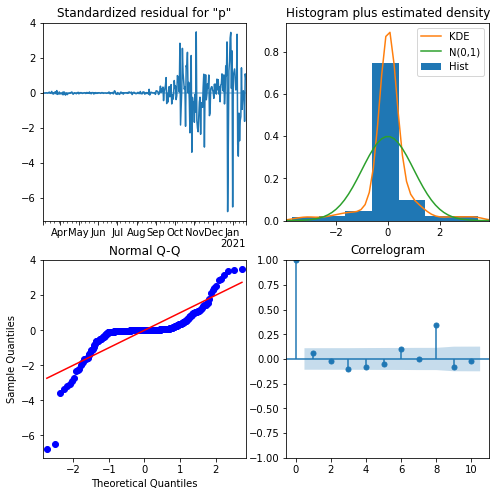

In [16]:
model.plot_diagnostics(figsize=(8,8))
plt.show()

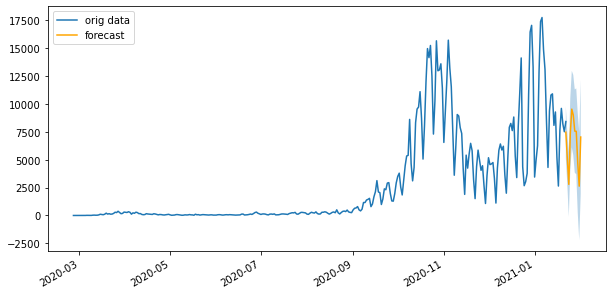

In [20]:
preds = model.get_prediction(start='2021-01-22', end='2021-02-01', dynamic=False)
preds_df = preds.summary_frame()
# print(preds_df)
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(data, label='orig data')
preds_df['mean'].plot(ax=ax, label=r'forecast', color='orange')
ax.fill_between(preds_df.index, preds_df['mean_ci_lower'],
                preds_df['mean_ci_upper'], alpha=0.3)
plt.legend()

Predikce do budoucna pro nás nevypadají příliš pozitivně :(